In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [12]:
import os
import time
import subprocess
from matplotlib import pyplot as plt
import datetime
import pandas as pd

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as f

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

import awoc
my_world = awoc.AWOC()

In [3]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

##Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [4]:
from google.cloud import storage

In [5]:
def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))

In [6]:
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [7]:
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        blob.delete()

### Read Data

In [20]:
geo_df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/pranavr569/tweets_classified')

In [21]:
geo_df.select('tweet_id').distinct().count()

12875304

In [22]:
geo_df = geo_df.dropDuplicates()

In [23]:
geo_df.count()

12875304

### Mapping the all locations into regions to find overall distribution

In [24]:
overall_count = geo_df.groupBy('user_location')\
         .agg(f.count('tweet_id').alias('total_twitterers')).orderBy('total_twitterers',ascending=False)

In [25]:
na_ctry = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY','Texas','USA','US','United States',
            'Canada','canada','Toronto','toronto','Ontario','ontario',"Alaska", "Alabama",
             "Arkansas", "American Samoa", "Arizona", "California", "Colorado",
             "Connecticut", "District ", "of Columbia", "Delaware", "Florida", 
             "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana",
             "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", 
             "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina",
             "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", 
             "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", 
             "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", 
             "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming",
             "Aberdeen", "Abilene", "Akron", "Albany", "Albuquerque", "Alexandria", "Allentown",
             "Amarillo", "Anaheim", "Anchorage", "Ann Arbor", "Antioch", "Apple Valley", "Appleton",
             "Arlington", "Arvada", "Asheville", "Athens", "Atlanta", "Atlantic City", "Augusta", 
             "Aurora", "Austin", "Bakersfield", "Baltimore", "Barnstable", "Baton Rouge", "Beaumont",
             "Bel Air", "Bellevue", "Berkeley", "Bethlehem", "Billings", "Birmingham", "Bloomington", 
             "Boise", "Boise City", "Bonita Springs", "Boston", "Boulder", "Bradenton", "Bremerton",
             "Bridgeport", "Brighton", "Brownsville", "Bryan", "Buffalo", "Burbank", "Burlington",
             "Cambridge", "Canton", "Cape Coral", "Carrollton", "Cary", "Cathedral City", "Cedar Rapids", 
             "Champaign", "Chandler", "Charleston", "Charlotte", "Chattanooga", "Chesapeake", "Chicago",
             "Chula Vista", "Cincinnati", "Clarke County", "Clarksville", "Clearwater", "Cleveland", 
             "College Station", "Colorado Springs", "Columbia", "Columbus", "Concord", "Coral Springs", 
             "Corona", "Corpus Christi", "Costa Mesa", "Dallas", "Daly City", "Danbury", "Davenport", 
             "Davidson County", "Dayton", "Daytona Beach", "Deltona", "Denton", "Denver", "Des Moines",
             "Detroit", "Downey", "Duluth", "Durham", "El Monte", "El Paso", "Elizabeth", "Elk Grove",
             "Elkhart", "Erie", "Escondido", "Eugene", "Evansville", "Fairfield", "Fargo", "Fayetteville",
             "Fitchburg", "Flint", "Fontana", "Fort Collins", "Fort Lauderdale", "Fort Smith",
             "Fort Walton Beach", "Fort Wayne", "Fort Worth", "Frederick", "Fremont", "Fresno", 
             "Fullerton", "Gainesville", "Garden Grove", "Garland", "Gastonia", "Gilbert", "Glendale",
             "Grand Prairie", "Grand Rapids", "Grayslake", "Green Bay", "GreenBay", "Greensboro",
             "Greenville", "Gulfport-Biloxi", "Hagerstown", "Hampton", "Harlingen", "Harrisburg", 
             "Hartford", "Havre de Grace", "Hayward", "Hemet", "Henderson", "Hesperia", "Hialeah",
             "Hickory", "High Point", "Hollywood", "Honolulu", "Houma", "Houston", "Howell", "Huntington", 
             "Huntington Beach", "Huntsville", "Independence", "Indianapolis", "Inglewood", "Irvine", 
             "Irving", "Jackson", "Jacksonville", "Jefferson", "Jersey City", "Johnson City", "Joliet", 
             "Kailua", "Kalamazoo", "Kaneohe", "Kansas City", "Kennewick", "Kenosha", "Killeen", "Kissimmee", 
             "Knoxville", "Lacey", "Lafayette", "Lake Charles", "Lakeland", "Lakewood", "Lancaster", "Lansing",
             "Laredo", "Las Cruces", "Las Vegas", "Layton", "Leominster", "Lewisville", "Lexington", "Lincoln",
             "Little Rock", "Long Beach", "Lorain", "Los Angeles", "Louisville", "Lowell", "Lubbock", "Macon",
             "Madison", "Manchester", "Marina", "Marysville", "McAllen", "McHenry", "Medford", "Melbourne", 
             "Memphis", "Merced", "Mesa", "Mesquite", "Miami", "Milwaukee", "Minneapolis", "Miramar",
             "Mission Viejo", "Mobile", "Modesto", "Monroe", "Monterey", "Montgomery", "Moreno Valley", 
             "Murfreesboro", "Murrieta", "Muskegon", "Myrtle Beach", "Naperville", "Naples", "Nashua", 
             "Nashville", "New Bedford", "New Haven", "New London", "New Orleans", "New York", "New York City",
             "Newark", "Newburgh", "Newport News", "Norfolk", "Normal", "Norman", "North Charleston", 
             "North Las Vegas", "North Port", "Norwalk", "Norwich", "Oakland", "Ocala", "Oceanside",
             "Odessa", "Ogden", "Oklahoma City", "Olathe", "Olympia", "Omaha", "Ontario", "Orange", 
             "Orem", "Orlando", "Overland Park", "Oxnard", "Palm Bay", "Palm Springs", "Palmdale", 
             "Panama City", "Pasadena", "Paterson", "Pembroke Pines", "Pensacola", "Peoria", "Philadelphia", 
             "Phoenix", "Pittsburgh", "Plano", "Pomona", "Pompano Beach", "Port Arthur", "Port Orange", 
             "Port Saint Lucie", "Port St. Lucie", "Portland", "Portsmouth", "Poughkeepsie", "Providence", 
             "Provo", "Pueblo", "Punta Gorda", "Racine", "Raleigh", "Rancho Cucamonga", "Reading", "Redding",
             "Reno", "Richland", "Richmond", "Richmond County", "Riverside", "Roanoke", "Rochester", "Rockford",
             "Roseville", "Round Lake Beach", "Sacramento", "Saginaw", "Saint Louis", "Saint Paul", 
             "Saint Petersburg", "Salem", "Salinas", "Salt Lake City", "San Antonio", "San Bernardino", 
             "San Buenaventura", "San Diego", "San Francisco", "San Jose", "Santa Ana", "Santa Barbara",
             "Santa Clara", "Santa Clarita", "Santa Cruz", "Santa Maria", "Santa Rosa", "Sarasota", 
             "Savannah", "Scottsdale", "Scranton", "Seaside", "Seattle", "Sebastian", "Shreveport", 
             "Simi Valley", "Sioux City", "Sioux Falls", "South Bend", "South Lyon", "Spartanburg", 
             "Spokane", "Springdale", "Springfield", "St. Louis", "St. Paul", "St. Petersburg", "Stamford", 
             "Sterling Heights", "Stockton", "Sunnyvale", "Syracuse", "Tacoma", "Tallahassee", "Tampa",
             "Temecula", "Tempe", "Thornton", "Thousand Oaks", "Toledo", "Topeka", "Torrance", "Trenton",
             "Tucson", "Tulsa", "Tuscaloosa", "Tyler", "Utica", "Vallejo", "Vancouver", "Vero Beach", 
             "Victorville", "Virginia Beach", "Visalia", "Waco", "Warren", "Washington", "Waterbury", 
             "Waterloo", "West Covina", "West Valley City", "Westminster", "Wichita", "Wilmington", 
             "Winston", "Winter Haven", "Worcester", "Yakima", "Yonkers", "York", "Youngstown"]

na_ctry_reg='|'.join(["(" + c +")" for c in na_ctry])

af_ctry = my_world.get_countries_list_of('Africa')
af_ctry_reg='|'.join(["(" + c +")" for c in af_ctry])

eu_ctry = my_world.get_countries_list_of('Europe')
eu_ctry_uk_reg = [*eu_ctry,*['London','England','UK','United Kingdom','Scotland']]
eu_ctry_reg='|'.join(["(" + c +")" for c in eu_ctry_uk_reg])

oc_ctry = my_world.get_countries_list_of('Oceania')
oc_ctry_reg='|'.join(["(" + c +")" for c in oc_ctry])

sa_ctry = my_world.get_countries_list_of('South America')
sa_ctry_reg='|'.join(["(" + c +")" for c in sa_ctry])

as_ctry = my_world.get_countries_list_of('Asia')
as_ctry_reg='|'.join(["(" + c +")" for c in as_ctry])

cont_df = overall_count\
.withColumn('Region',f.when(overall_count['user_location'].rlike(na_ctry_reg), 'North America')\
            .when(overall_count['user_location'].rlike(af_ctry_reg), 'Africa')\
            .when(overall_count['user_location'].rlike(sa_ctry_reg), 'South America')\
            .when(overall_count['user_location'].rlike(oc_ctry_reg), 'Oceania')\
            .when(overall_count['user_location'].rlike(eu_ctry_reg), 'Europe')\
            .when(overall_count['user_location'].rlike(as_ctry_reg), 'Asia')\
            .otherwise(overall_count['user_location']))



In [26]:
cont = ['Africa','North America','South America','Asia','Europe','Oceania']
cont_reg='|'.join(["(" + c +")" for c in cont])

In [27]:
overall_reg_df = cont_df.groupBy('Region').agg(sum('total_twitterers').alias('total_twitterers'))\
.orderBy('total_twitterers',ascending=False)\
.na.drop(subset=['Region'])\
.filter(cont_df['Region'].rlike(cont_reg))

### Plot of the Overall Geographical Description 

In [34]:
overall_reg_df

<bound method DataFrame.printSchema of DataFrame[Region: string, total_twitterers: bigint]>

In [33]:
overall_reg_df.dtypes

[('Region', 'string'), ('total_twitterers', 'bigint')]

In [37]:
a = overall_reg_df.toPandas()

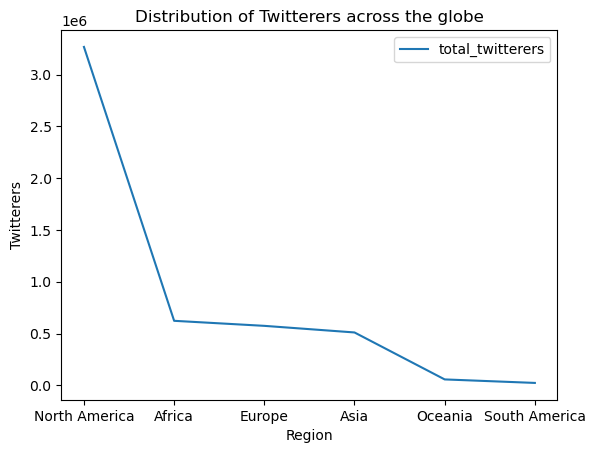

In [50]:

fig = a.head(6).plot(kind='line', x = 'Region')
fig.set_xlabel('Region')
fig.set_ylabel('Twitterers')
fig.set_title('Distribution of Twitterers across the globe')
plt.show()

In [51]:
geo_df.count()

12875304